In [1]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/BXDLongevity"

In [2]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
# using GeneNetworkAPI, Downloads
using BenchmarkTools
using Plots

In [3]:
sampled_traits = readdlm("output/samples1000.txt", '\t') |> vec |> x -> Int.(x);

In [4]:
function meanAbsDiff(x, y)
    
    return mean(abs.(x .- y))
    
end

meanAbsDiff (generic function with 1 method)

In [5]:
function removeInfValues!(x, y, toRemove)
    
    for inf_val in toRemove
        
        x[inf_val[1], inf_val[2]] = 0.0;
        y[inf_val[1], inf_val[2]] = 0.0;
        
    end
    
end

removeInfValues! (generic function with 1 method)

In [44]:
samples = Int.(readdlm("output/samples1000.txt")) |> vec;

## Individual LP:

In [162]:
bulklmm_results_ind_null = readdlm("output/bulklmm_L_ind_null_corrected10.txt", '\t');

In [163]:
bulklmm_results_ind_null_nc = readdlm("output/bulklmm_L_ind_null.txt", '\t');

In [8]:
bulklmm_results_ind_null_grid10 = readdlm("output/bulklmm_L_ind_null_grid10.txt", '\t');

In [9]:
bulklmm_results_ind_null_grid20 = readdlm("output/bulklmm_L_ind_null_grid20.txt", '\t');

In [10]:
bulklmm_results_ind_null_grid100 = readdlm("output/bulklmm_L_ind_null_grid100.txt", '\t');

In [11]:
bulklmm_results_ind_alt_grid10 = readdlm("output/bulklmm_L_ind_alt_grid10.txt", '\t');

In [12]:
bulklmm_results_ind_alt_grid20 = readdlm("output/bulklmm_L_ind_alt_grid20.txt", '\t');

In [13]:
bulklmm_results_ind_alt_grid100 = readdlm("output/bulklmm_L_ind_alt_grid100.txt", '\t');

In [198]:
bulklmm_results_ind_LM = readdlm("output/bulklmm_L_ind_LM.txt", '\t');

In [14]:
@time gemma_results_ind = readdlm("output/gemma_L_ind.txt", '\t');

 30.154896 seconds (465.13 M allocations: 11.767 GiB, 4.47% gc time)


In [15]:
copy_gemma = copy(gemma_results_ind);

In [16]:
toRemove = findall(isinf.(copy_gemma));

In [200]:
removeInfValues!(gemma_results_ind, bulklmm_results_ind_null, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_null_nc, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_null_grid10, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_null_grid20, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_null_grid100, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_LM, toRemove)

In [165]:
removeInfValues!(gemma_results_ind, bulklmm_results_ind_alt_grid10, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_alt_grid20, toRemove)
removeInfValues!(gemma_results_ind, bulklmm_results_ind_alt_grid100, toRemove)

In [166]:
mad_null_exact = meanAbsDiff(bulklmm_results_ind_null, gemma_results_ind);
mad_null_grid10 = meanAbsDiff(bulklmm_results_ind_null_grid10, gemma_results_ind);
mad_null_grid20 = meanAbsDiff(bulklmm_results_ind_null_grid20, gemma_results_ind);
mad_null_grid100 = meanAbsDiff(bulklmm_results_ind_null_grid100, gemma_results_ind);
mad_alt_grid10 = meanAbsDiff(bulklmm_results_ind_alt_grid10, gemma_results_ind);
mad_alt_grid20 = meanAbsDiff(bulklmm_results_ind_alt_grid20, gemma_results_ind);
mad_alt_grid100 = meanAbsDiff(bulklmm_results_ind_alt_grid100, gemma_results_ind);

In [167]:
method_names = ["null-exact", "null-grid-0.1", "null-grid-0.05", "null-grid-0.01", "alt-grid-0.1", "alt-grid-0.05", "alt-grid-0.01"];

In [168]:
lp_ind_mad_summary = DataFrame(hcat(method_names, 
                                    [mad_null_exact, 
                                     mad_null_grid10, 
                                     mad_null_grid20, 
                                     mad_null_grid100,
                                     mad_alt_grid10, 
                                     mad_alt_grid20, 
                                     mad_alt_grid100]), ["Method", "MAD"])

Row,Method,MAD
,Any,Any
1,null-exact,0.00945291
2,null-grid-0.1,0.0175829
3,null-grid-0.05,0.0118635
4,null-grid-0.01,0.00958179
5,alt-grid-0.1,0.0105052
6,alt-grid-0.05,0.00383394
7,alt-grid-0.01,0.000968753


In [183]:
size(bulklmm_results_ind_null_grid10)

(7321, 1000)

In [201]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    return lod

end

function lod2p(lod::Float64, df::Int64)
    
    lrs = lod*2*log(10);
    pval = 1-cdf(Chisq(df), lrs)
    
    return pval
    
end

lod2p (generic function with 1 method)

In [202]:
# samples_lod = sample(1:(7321000), 1000)
# writedlm("output/samples_veclods1000.txt", samples_lod, '\t');
samples_lod = Int.(readdlm("output/samples_veclods1000.txt", '\t')) |> vec;

In [203]:
logp_gemma = lod2p.(vec(gemma_results_ind)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_null_exact = lod2p.(vec(bulklmm_results_ind_null)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_null_exact_nc = lod2p.(vec(bulklmm_results_ind_null_nc)[samples_lod], 1) |> x -> -log10.(x); # without correction
logp_bulklmm_null_grid10 = lod2p.(vec(bulklmm_results_ind_null_grid10)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_alt_grid10 = lod2p.(vec(bulklmm_results_ind_alt_grid10)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_null_grid100 = lod2p.(vec(bulklmm_results_ind_null_grid100)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_alt_grid100 = lod2p.(vec(bulklmm_results_ind_alt_grid100)[samples_lod], 1) |> x -> -log10.(x);
logp_bulklmm_LM = lod2p.(vec(bulklmm_results_ind_LM)[samples_lod], 1) |> x -> -log10.(x);

Comparing GEMMA with null's...

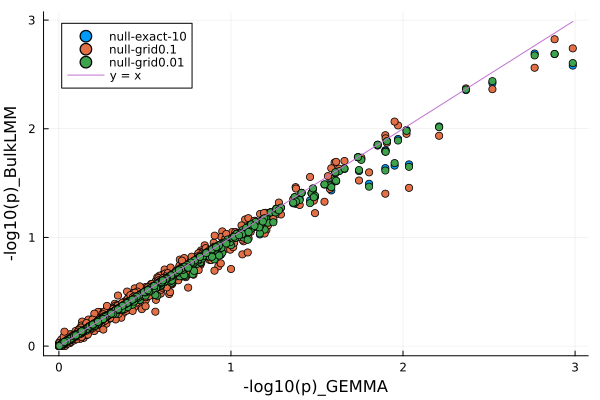

In [227]:
scatter(logp_gemma, logp_bulklmm_null_exact, label = "null-exact-10");
scatter!(logp_gemma, logp_bulklmm_null_grid10, label = "null-grid0.1");
scatter!(logp_gemma, logp_bulklmm_null_grid100, label = "null-grid0.01")
plot!(x -> x, label = "y = x", xaxis = "-log10(p)_GEMMA", yaxis = "-log10(p)_BulkLMM")

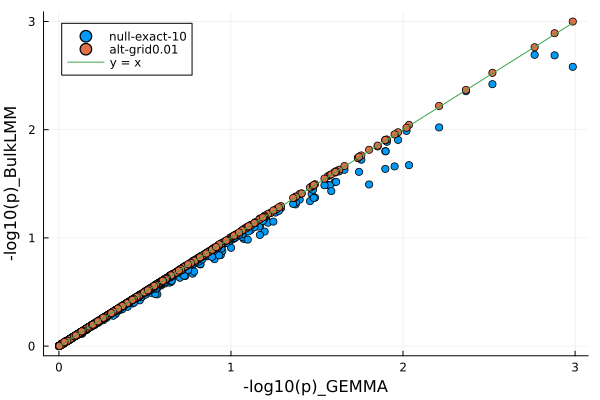

In [230]:
scatter(logp_gemma, logp_bulklmm_null_exact, label = "null-exact-10");
# scatter!(logp_gemma, logp_bulklmm_alt_grid10, label = "alt-grid0.1");
scatter!(logp_gemma, logp_bulklmm_alt_grid100, label = "alt-grid0.01")
plot!(x -> x, label = "y = x", xaxis = "-log10(p)_GEMMA", yaxis = "-log10(p)_BulkLMM")

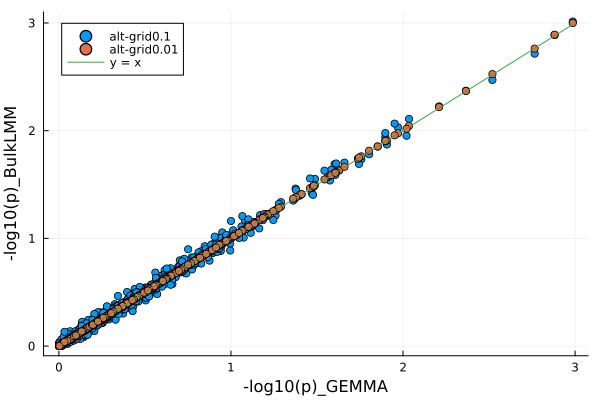

In [233]:
# scatter(logp_gemma, logp_bulklmm_null_exact, label = "null-exact");
scatter(logp_gemma, logp_bulklmm_alt_grid10, label = "alt-grid0.1");
scatter!(logp_gemma, logp_bulklmm_alt_grid100, label = "alt-grid0.01")
plot!(x -> x, label = "y = x", xaxis = "-log10(p)_GEMMA", yaxis = "-log10(p)_BulkLMM")

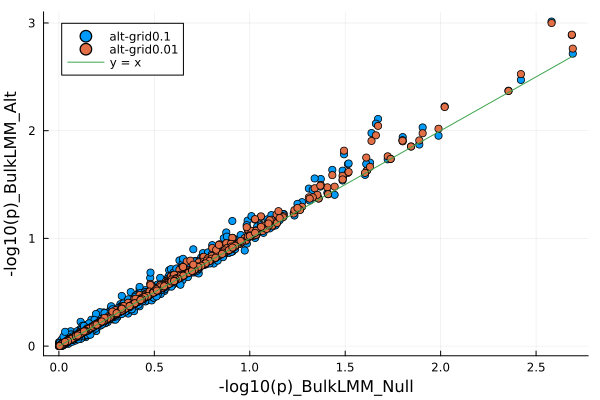

In [234]:
scatter(logp_bulklmm_null_exact, logp_bulklmm_alt_grid10, label = "alt-grid0.1");
scatter!(logp_bulklmm_null_exact, logp_bulklmm_alt_grid100, label = "alt-grid0.01")
plot!(x -> x, label = "y = x", yaxis = "-log10(p)_BulkLMM_Alt", xaxis = "-log10(p)_BulkLMM_Null")

In [217]:
larger = findall(logp_bulklmm_alt_grid100 .>= logp_bulklmm_null_exact)

789-element Vector{Int64}:
    1
    3
    4
    6
    7
    8
    9
   10
   13
   14
   16
   17
   18
    ⋮
  984
  987
  988
  991
  992
  993
  994
  995
  996
  998
  999
 1000

In [218]:
maximum(logp_bulklmm_alt_grid100[larger] .- logp_bulklmm_null_exact[larger])

0.418381000063456

In [220]:
minimum(logp_bulklmm_alt_grid100[:] .- logp_bulklmm_null_exact[:])

-0.009053821300154086

In [224]:
mean(logp_gemma[:] .>= logp_bulklmm_null_exact[:])

0.709

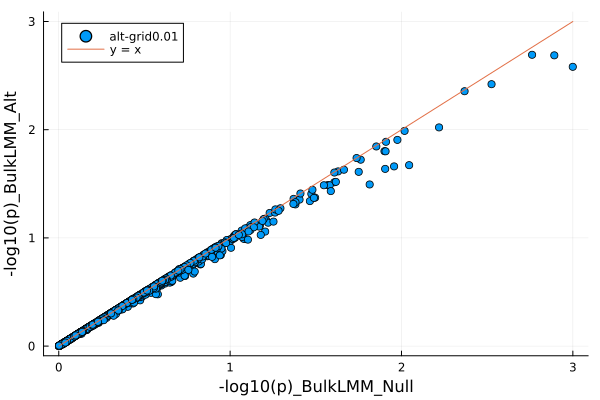

In [225]:
scatter(logp_bulklmm_alt_grid100, logp_bulklmm_null_exact, label = "alt-grid0.01")
plot!(x -> x, label = "y = x", yaxis = "-log10(p)_BulkLMM_Alt", xaxis = "-log10(p)_BulkLMM_Null")

In [235]:
mean(logp_bulklmm_alt_grid100 .>= logp_bulklmm_null_exact)

0.789

In [239]:
maximum(logp_bulklmm_alt_grid10 .- logp_gemma)

0.16089588861653636

In [241]:
minimum(logp_bulklmm_alt_grid10 .- logp_gemma)

-0.10841074479217283

In [240]:
mean(logp_bulklmm_alt_grid100 .- logp_gemma)

0.0010966854210881717

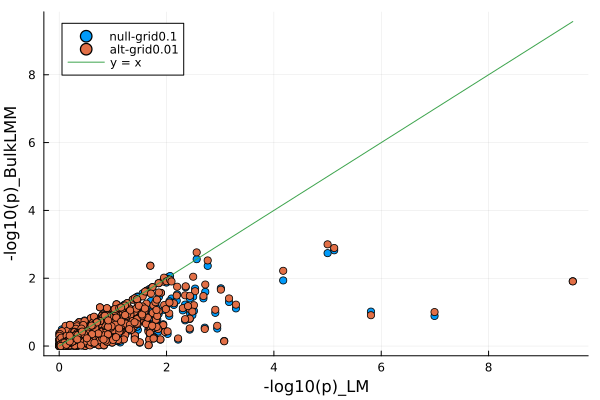

In [236]:
scatter(logp_bulklmm_LM, logp_bulklmm_null_grid10, label = "null-grid0.1");
scatter!(logp_bulklmm_LM, logp_bulklmm_alt_grid100, label = "alt-grid0.01");
plot!(x -> x, label = "y = x", yaxis = "-log10(p)_BulkLMM", xaxis = "-log10(p)_LM")

In [296]:
mean(logp_bulklmm_LM .>= logp_bulklmm_alt_grid100)

0.705

In [299]:
inflated_p = findall(logp_bulklmm_LM .>= logp_bulklmm_alt_grid100);

In [321]:
findmax(logp_bulklmm_LM .- logp_bulklmm_alt_grid100)

(7.661831709823977, 284)

In [323]:
hcat(logp_bulklmm_LM[284], logp_bulklmm_alt_grid100[284])

1×2 Matrix{Float64}:
 9.56886  1.90703

In [252]:
minimum(logp_bulklmm_LM .- logp_bulklmm_alt_grid100)

-0.6698174840272648

In [301]:
mean((logp_bulklmm_LM[inflated_p] .- logp_bulklmm_alt_grid100[inflated_p]) .<= 0.5)

0.8141843971631205

In [304]:
mean(map(x -> (x >= 0.5) & (x <= 1.0), logp_bulklmm_LM[inflated_p] .- logp_bulklmm_alt_grid100[inflated_p]))

0.11914893617021277

In [305]:
mean(map(x -> (x >= 1.0) & (x < 1.5), logp_bulklmm_LM[inflated_p] .- logp_bulklmm_alt_grid100[inflated_p]))

0.03546099290780142

In [314]:
mean(map(x -> (x >= 1.5) & (x < 2.0), logp_bulklmm_LM[inflated_p] .- logp_bulklmm_alt_grid100[inflated_p]))

0.018439716312056736

In [ ]:
-log10(0.05)

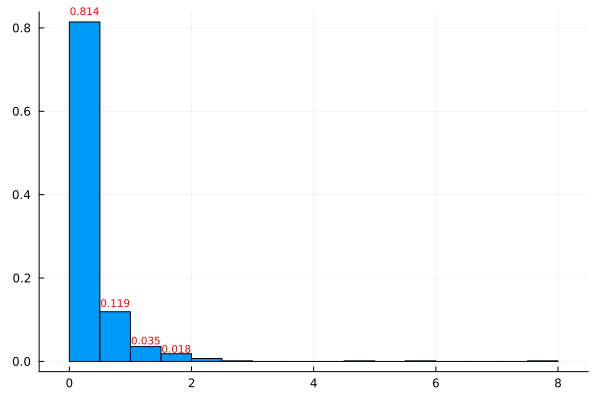

In [319]:
histogram(logp_bulklmm_LM .- logp_bulklmm_alt_grid100; 
          label = false, bins = 0:0.5:ceil(maximum(logp_bulklmm_LM .- logp_bulklmm_alt_grid100)),
          normalize=:probability)
annotate!([0.25], [0.84], ("0.814", 7, "red"))
annotate!([0.75], [0.14], ("0.119", 7, "red"))
annotate!([1.25], [0.05], ("0.035", 7, "red"))
annotate!([1.75], [0.03], ("0.018", 7, "red"))

In [194]:
findall(logp_bulklmm_null_exact_nc .!== logp_bulklmm_null_exact)

894-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   12
   13
   14
    ⋮
  987
  988
  990
  991
  992
  993
  994
  995
  996
  998
  999
 1000

In [195]:
maximum(abs.(logp_bulklmm_null_exact_nc .- logp_bulklmm_null_exact))

1.37213221562682e-7

In [180]:
-log10(lod2p(3.8, 1))

4.541572055696799

In [181]:
-log10(lod2p(3.4, 1))

4.1197136992337855

In [182]:
-log10(lod2p(2.85, 1))

3.5354768154414287